$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [2]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [3]:
import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs3600.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /Users/I341716/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /Users/I341716/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /Users/I341716/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [4]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


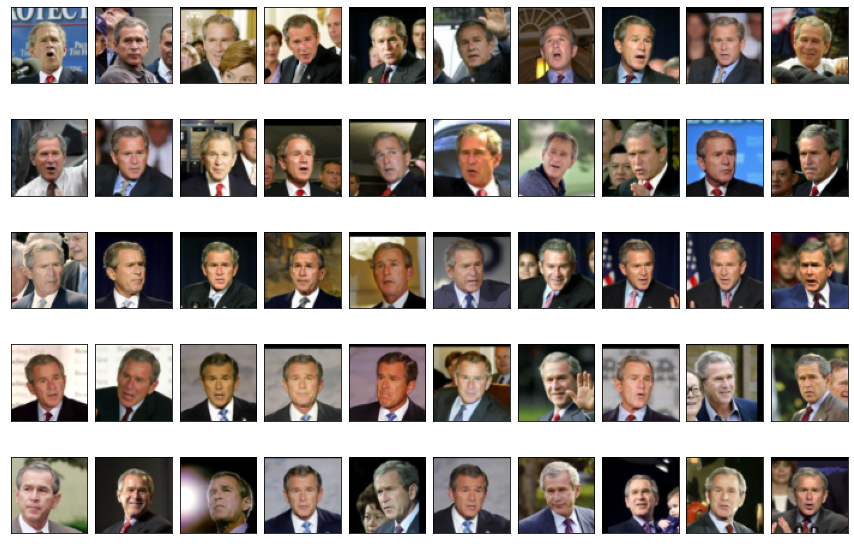

In [5]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [6]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [10]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [11]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (fc): Linear(in_features=128, out_features=16384, bias=True)
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [12]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [13]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

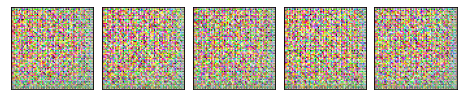

In [14]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [15]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:51<00:00,  6.53s/it]
Discriminator loss: 0.8333183632177465
Generator loss:     3.2745560968623444


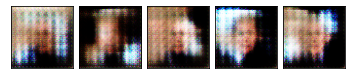

--- EPOCH 2/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:55<00:00,  6.81s/it]
Discriminator loss: 0.5716441326281604
Generator loss:     3.5478424114339493


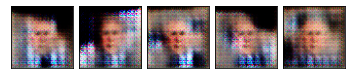

--- EPOCH 3/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:55<00:00,  6.79s/it]
Discriminator loss: 0.7108644422362832
Generator loss:     4.411110849941478


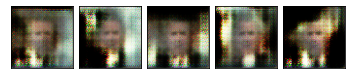

--- EPOCH 4/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:49<00:00,  6.42s/it]
Discriminator loss: 1.1178374325527864
Generator loss:     3.1062378567807816


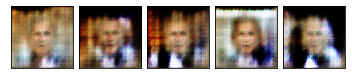

--- EPOCH 5/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:45<00:00,  6.23s/it]
Discriminator loss: 0.6932187518652748
Generator loss:     3.4829945511677685


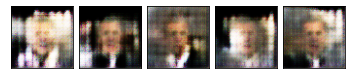

--- EPOCH 6/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:51<00:00,  6.54s/it]
Discriminator loss: 0.9165457031306099
Generator loss:     3.311594184707193


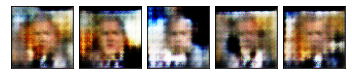

--- EPOCH 7/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:54<00:00,  6.76s/it]
Discriminator loss: 0.7674240487463334
Generator loss:     3.363108045914594


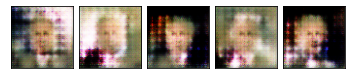

--- EPOCH 8/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:52<00:00,  6.63s/it]
Discriminator loss: 0.9738032484755796
Generator loss:     3.549755159546347


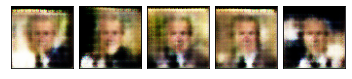

--- EPOCH 9/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:55<00:00,  6.82s/it]
Discriminator loss: 0.5171262166079353
Generator loss:     3.603993941755856


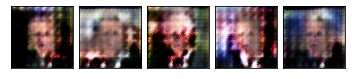

--- EPOCH 10/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:57<00:00,  6.90s/it]
Discriminator loss: 0.6954225187792498
Generator loss:     3.9059174060821533


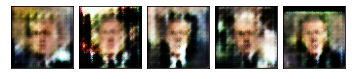

--- EPOCH 11/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:55<00:00,  6.81s/it]
Discriminator loss: 0.5607968279544044
Generator loss:     4.231065273284912


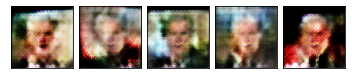

--- EPOCH 12/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:53<00:00,  6.66s/it]
Discriminator loss: 0.7599588115425671
Generator loss:     4.2689821860369515


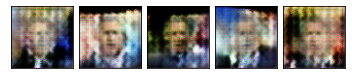

--- EPOCH 13/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.38s/it]
Discriminator loss: 0.5722639692180297
Generator loss:     3.718543164870318


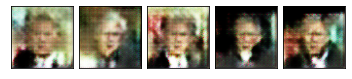

--- EPOCH 14/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.6268229182152187
Generator loss:     4.3959983587265015


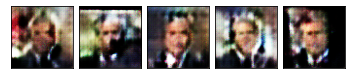

--- EPOCH 15/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:45<00:00,  6.23s/it]
Discriminator loss: 0.6972346805474338
Generator loss:     4.130782113355749


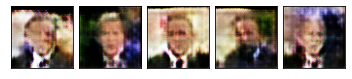

--- EPOCH 16/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.25s/it]
Discriminator loss: 0.3741423040628433
Generator loss:     4.384205397437601
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


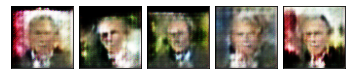

--- EPOCH 17/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.698550828239497
Generator loss:     4.373219994937672


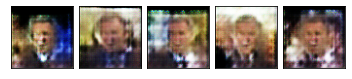

--- EPOCH 18/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.29s/it]
Discriminator loss: 0.5445761991774335
Generator loss:     4.546149667571573


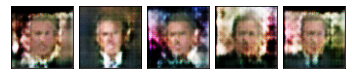

--- EPOCH 19/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.3151576133335338
Generator loss:     4.736009078867295
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


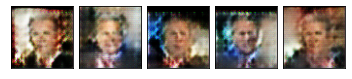

--- EPOCH 20/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.33s/it]
Discriminator loss: 0.5557547012234435
Generator loss:     4.897187134798835


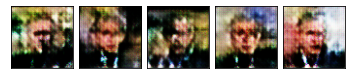

--- EPOCH 21/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.2742002264541738
Generator loss:     4.961156284107881
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


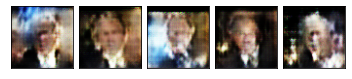

--- EPOCH 22/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.503536627134856
Generator loss:     5.549856448874754


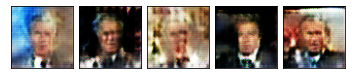

--- EPOCH 23/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.5075113186064888
Generator loss:     5.047484285691205


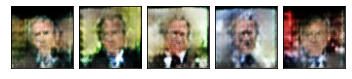

--- EPOCH 24/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:49<00:00,  6.46s/it]
Discriminator loss: 0.6316647590959773
Generator loss:     4.816737104864681


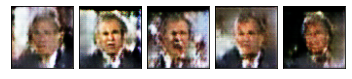

--- EPOCH 25/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.41595759418080835
Generator loss:     4.832599625867956


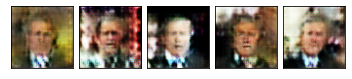

--- EPOCH 26/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.26802484296700535
Generator loss:     5.360840348636403
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


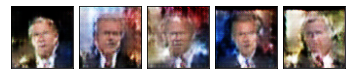

--- EPOCH 27/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.6585944641162368
Generator loss:     5.205134454895468


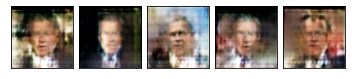

--- EPOCH 28/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.3378346246831557
Generator loss:     4.906324639039881


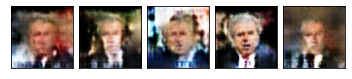

--- EPOCH 29/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.2776491646380985
Generator loss:     5.623984519173117


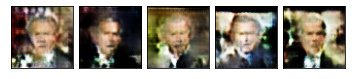

--- EPOCH 30/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.45162922319243937
Generator loss:     5.852442068212173


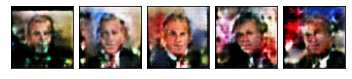

--- EPOCH 31/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.21506850268034375
Generator loss:     5.614222063737757
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


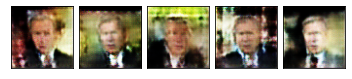

--- EPOCH 32/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.4062975005191915
Generator loss:     6.362122753087212


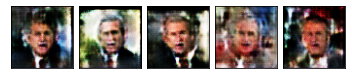

--- EPOCH 33/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.2630446005393477
Generator loss:     6.038327750037698


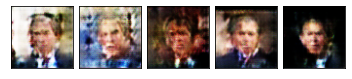

--- EPOCH 34/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.30s/it]
Discriminator loss: 0.4592801817857167
Generator loss:     5.99352899719687


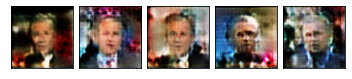

--- EPOCH 35/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.18027488514780998
Generator loss:     5.7518563551061295
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


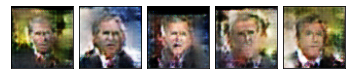

--- EPOCH 36/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.8125262490528471
Generator loss:     5.787686979069429


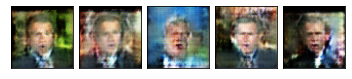

--- EPOCH 37/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.35s/it]
Discriminator loss: 0.2927919126608792
Generator loss:     5.2131754230050475


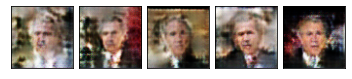

--- EPOCH 38/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.13875956132131465
Generator loss:     5.6981079438153435
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


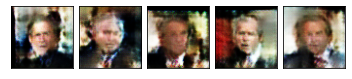

--- EPOCH 39/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.13355021792299607
Generator loss:     5.9225474245408005
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


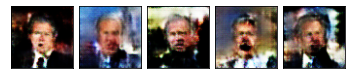

--- EPOCH 40/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.11686466387746965
Generator loss:     5.921260006287518
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


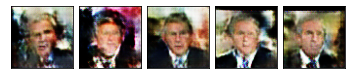

--- EPOCH 41/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.30s/it]
Discriminator loss: 0.1934428156956154
Generator loss:     6.839049479540656


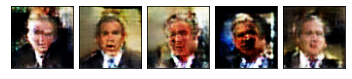

--- EPOCH 42/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.31s/it]
Discriminator loss: 0.31493906457634535
Generator loss:     6.890790069804472


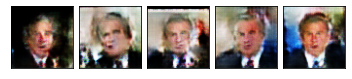

--- EPOCH 43/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.563328697510502
Generator loss:     6.265364085926729


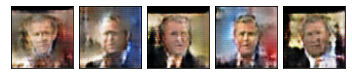

--- EPOCH 44/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.39s/it]
Discriminator loss: 0.2699318883173606
Generator loss:     5.900530282188864


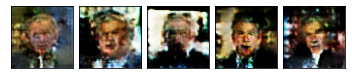

--- EPOCH 45/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.36s/it]
Discriminator loss: 0.20025226692943013
Generator loss:     5.9724211131825165


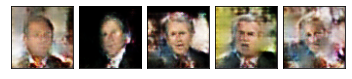

--- EPOCH 46/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.35s/it]
Discriminator loss: 0.10687330847277361
Generator loss:     6.2070503795848175
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


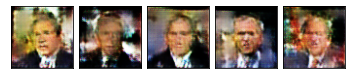

--- EPOCH 47/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.08385440290850751
Generator loss:     6.6496358338524315
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


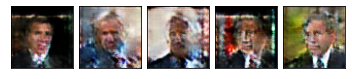

--- EPOCH 48/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.04931846765034339
Generator loss:     6.475116617539349
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


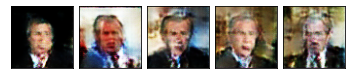

--- EPOCH 49/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.15016980381572947
Generator loss:     7.614586002686444


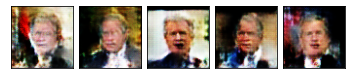

--- EPOCH 50/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.16783814307521372
Generator loss:     7.866737057180965


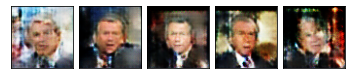

--- EPOCH 51/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.15278725621893124
Generator loss:     7.206898016088149


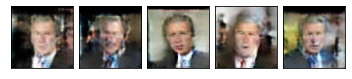

--- EPOCH 52/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.25s/it]
Discriminator loss: 0.6694448405109784
Generator loss:     7.510586556266336


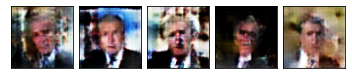

--- EPOCH 53/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.34s/it]
Discriminator loss: 0.38109232616775174
Generator loss:     5.850246317246381


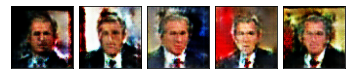

--- EPOCH 54/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.16258409948033445
Generator loss:     5.706296443939209


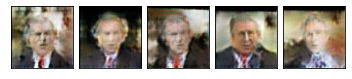

--- EPOCH 55/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.13586349368971937
Generator loss:     6.456833558924058


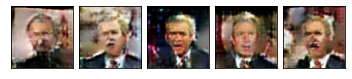

--- EPOCH 56/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.1087142212645096
Generator loss:     5.873678431791418


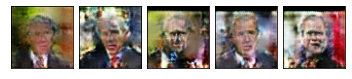

--- EPOCH 57/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.09862105581252013
Generator loss:     7.652619165532729


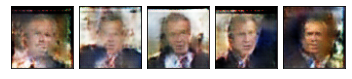

--- EPOCH 58/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.09970642870072932
Generator loss:     7.16074733173146


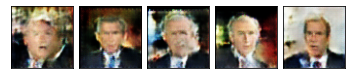

--- EPOCH 59/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.31s/it]
Discriminator loss: 0.05759093910455704
Generator loss:     7.057115863351261


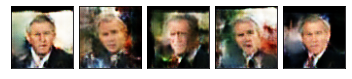

--- EPOCH 60/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.30s/it]
Discriminator loss: 0.8327183822060332
Generator loss:     7.530260703142951


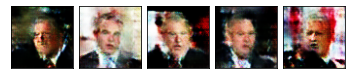

--- EPOCH 61/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.32s/it]
Discriminator loss: 0.24734800999217174
Generator loss:     5.576471637277042


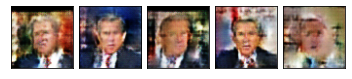

--- EPOCH 62/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.16227231328101718
Generator loss:     6.018882933784933


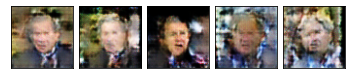

--- EPOCH 63/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.25s/it]
Discriminator loss: 0.11449371749425635
Generator loss:     5.909415693844066


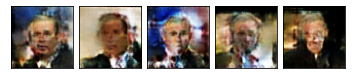

--- EPOCH 64/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.30s/it]
Discriminator loss: 0.07616004238233846
Generator loss:     6.684759869295008


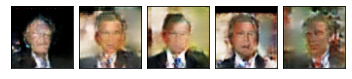

--- EPOCH 65/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.33s/it]
Discriminator loss: 0.056164101615329
Generator loss:     6.83483112559599


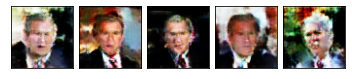

--- EPOCH 66/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.05537348700796857
Generator loss:     7.224940664627972


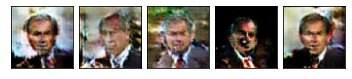

--- EPOCH 67/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.07944480740629575
Generator loss:     7.432373916401582


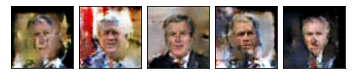

--- EPOCH 68/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.32s/it]
Discriminator loss: 0.5261617439853794
Generator loss:     8.050074745627011


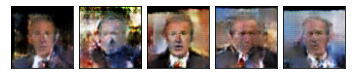

--- EPOCH 69/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.3633934447870535
Generator loss:     7.280041358050178


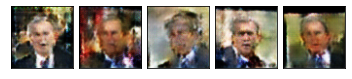

--- EPOCH 70/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.37s/it]
Discriminator loss: 0.11567269610788893
Generator loss:     6.630564353045295


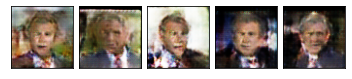

--- EPOCH 71/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.29s/it]
Discriminator loss: 0.044470554546398276
Generator loss:     7.276556043063893
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


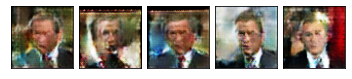

--- EPOCH 72/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.07304677575388376
Generator loss:     6.927231199601117


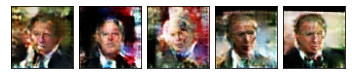

--- EPOCH 73/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.32s/it]
Discriminator loss: 0.023330716197105014
Generator loss:     8.019459500032312
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


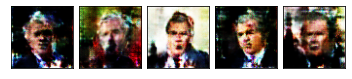

--- EPOCH 74/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.7591805357266875
Generator loss:     7.495597558863023


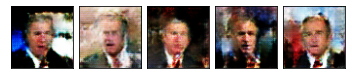

--- EPOCH 75/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.26s/it]
Discriminator loss: 0.1439028656219735
Generator loss:     5.7387235585381005


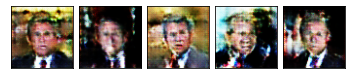

--- EPOCH 76/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.33s/it]
Discriminator loss: 0.05952870681443635
Generator loss:     6.297839108635397


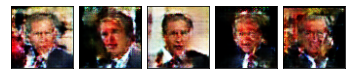

--- EPOCH 77/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.32s/it]
Discriminator loss: 0.08439848068005898
Generator loss:     6.626903197344611


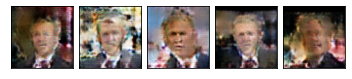

--- EPOCH 78/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:49<00:00,  6.43s/it]
Discriminator loss: 0.023625677561058718
Generator loss:     7.23743517258588


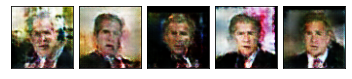

--- EPOCH 79/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.36s/it]
Discriminator loss: 0.03463057253290625
Generator loss:     7.399052451638615


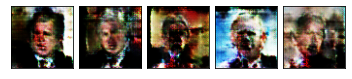

--- EPOCH 80/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.35s/it]
Discriminator loss: 0.03347227240309996
Generator loss:     7.67929074343513


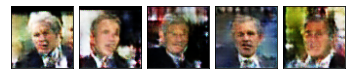

--- EPOCH 81/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.7027115035144722
Generator loss:     8.404377839144539


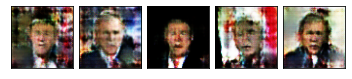

--- EPOCH 82/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.15484674713190863
Generator loss:     7.071968134711771


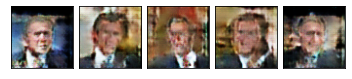

--- EPOCH 83/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.14745023671318502
Generator loss:     7.245052702286664


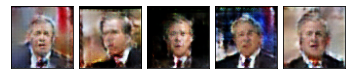

--- EPOCH 84/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.08792740566765561
Generator loss:     7.1149906831629135


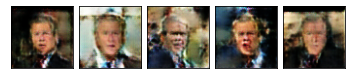

--- EPOCH 85/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.058664876529399085
Generator loss:     6.959129221299115


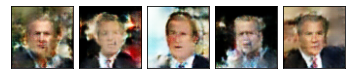

--- EPOCH 86/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.31s/it]
Discriminator loss: 0.03851442526587669
Generator loss:     6.903597495135139


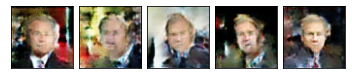

--- EPOCH 87/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.34s/it]
Discriminator loss: 0.039498760638868105
Generator loss:     7.324329712811639


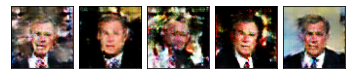

--- EPOCH 88/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.02417410767691977
Generator loss:     7.991826169631061


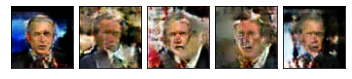

--- EPOCH 89/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.36s/it]
Discriminator loss: 0.11590850725769997
Generator loss:     8.934687852859497


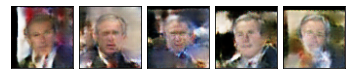

--- EPOCH 90/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.30s/it]
Discriminator loss: 0.045513925087802554
Generator loss:     9.116410956663245


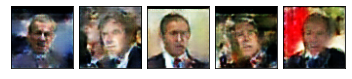

--- EPOCH 91/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.11463501052383114
Generator loss:     8.599410926594453


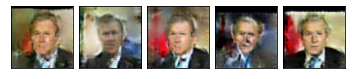

--- EPOCH 92/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.33s/it]
Discriminator loss: -0.00851377790026805
Generator loss:     7.919020091786104
*** Saved checkpoint file: checkpoints/gan.pt, based on the Discriminator Loss.
Saved checkpoint.


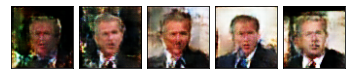

--- EPOCH 93/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.14962155448601527
Generator loss:     8.523129407097311


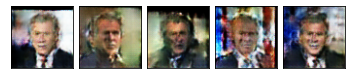

--- EPOCH 94/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.28s/it]
Discriminator loss: 0.040393029723097294
Generator loss:     8.74404239654541


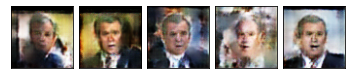

--- EPOCH 95/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:48<00:00,  6.36s/it]
Discriminator loss: 0.10831368079080302
Generator loss:     7.322579019209918


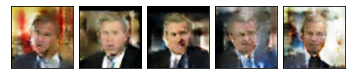

--- EPOCH 96/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.30s/it]
Discriminator loss: 0.19732455142280636
Generator loss:     9.757026391870836


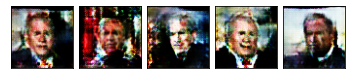

--- EPOCH 97/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.27s/it]
Discriminator loss: 0.04279262610875508
Generator loss:     9.218746381647447


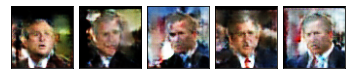

--- EPOCH 98/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.01953040950876825
Generator loss:     8.260650831110338


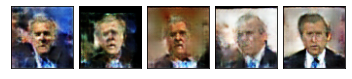

--- EPOCH 99/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.29s/it]
Discriminator loss: 0.10880241433487219
Generator loss:     9.991444812101477


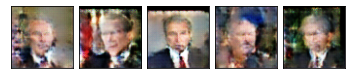

--- EPOCH 100/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.32s/it]
Discriminator loss: 0.022827446351156515
Generator loss:     8.694389679852653


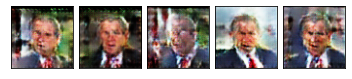

In [17]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


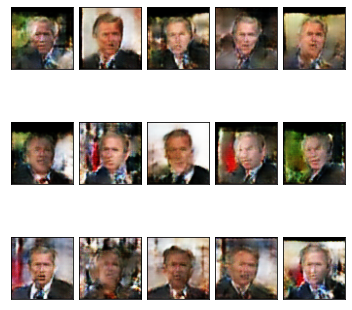

In [18]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [19]:
from cs3600.answers import display_answer
import hw4.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [20]:
display_answer(hw4.answers.part3_q1)


**Your answer:**
During the training phase, we're training both models, the discriminator model, and the generator model simultaneously, which lead us to perform sampling in two different cases:
* When we compute the generator's loss, we use the forward function on the sampled objects from the sampling function. Then, when we calculate the loss we will need those samples to be in the generator's computation graph. Hence, we maintain gradients when sampling from the GAN.
* When we compute the loss over the discriminator model, the gradients are irrelevant, since we use the sampled object for applying the discriminator path. Hence, we don't need to maintain gradients.


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [21]:
display_answer(hw4.answers.part3_q2)


**Your answer:**
1. No, because if the discriminator isn't performing good results in the training phase, then the generator's loss can decrease below a given threshold, despite the fact that the generator model isn't performing well.
The reason is that the generator's loss might decrease when the generator is performing better results or when the discriminator is getting poor results.

2. It means that both the generator and the discriminator are performing good results. The generator produces more likely samples to the original images and the discriminator performs good classifications between the original and fake images.


### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [22]:
display_answer(hw4.answers.part3_q3)


**Your answer:**
GANs yield better results as compared to VAE. In VAE, we optimize the lower variational bound whereas in GAN, there is no such assumption. GANs don’t deal with any explicit probability density estimation, however, it performs a more complex loss function during the training phase. The failure of VAE in generating sharp images implies that the model is not able to learn the true posterior distribution, while GAN produces more creative images (despite the blurriness).
